## Case Study: Breast Cancer Diagnosis

This case study explores a medical decision-making task: breast cancer diagnosis. We will see how to use scikit-learn’s homogeneous parallel ensemble modules in practice.  Specifically, we will train and evaluate the performance of three homogeneous parallel algorithms, each characterized by increasing randomness: bagging with decision trees, random forests and ExtraTrees.

### Loading and pre-processing

In [1]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

# Convert to a Pandas DataFrame so we can visualize nicely
import pandas as pd
import numpy as np
df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
i = np.random.permutation(len(dataset['target']))
df = df.iloc[i, :7]
df['diagnosis'] = dataset['target'][i]
df = df.reset_index()
df.head()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,diagnosis
0,254,19.45,19.33,126.5,1169.0,0.10350,0.11880,0.13790,0
1,70,18.94,21.31,123.6,1130.0,0.09009,0.10290,0.10800,0
2,479,16.25,19.51,109.8,815.8,0.10260,0.18930,0.22360,0
3,319,12.43,17.00,78.6,477.3,0.07557,0.03454,0.01342,1
4,375,16.17,16.07,106.3,788.5,0.09880,0.14380,0.06651,1


In [2]:
X, y = dataset['data'], dataset['target']
rng=np.random.RandomState(seed=4190)     # Initialize a random number generator 

---

### Bagging, Random Forest and ExtraTrees

Once we have pre-processed our data set, we will train and evaluate bagging with decision trees, random forests and ExtraTrees in order to answer the following questions:
1.	How does the ensemble performance change with ensemble size? That is, what happens when our ensembles get bigger and bigger?
2.	How does the ensemble performance change with base learner complexity? That is, what happens when our individual base estimators become more and more complex. In this case study, since all three ensemble methods considered use decision trees as base estimators, one “measure” of complexity is tree depth, with deeper trees being more complex.

#### Ensemble size vs. ensemble performance
We compare the behavior of the three algorithms as the parameter n_estimators increases. 

**CAUTION: This experiment below runs slowly!**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

max_leaf_nodes = 8
n_runs = 30
n_estimator_range = range(2, 20, 1)

bag_trn_error = np.zeros((n_runs, len(n_estimator_range)))  # Train error for the bagging classifier
rf_trn_error = np.zeros((n_runs, len(n_estimator_range)))   # Train error for the random forest classifier
xt_trn_error = np.zeros((n_runs, len(n_estimator_range)))   # Train error for the extra trees classifier

bag_tst_error = np.zeros((n_runs, len(n_estimator_range)))  # Test error for the bagging classifier
rf_tst_error = np.zeros((n_runs, len(n_estimator_range)))   # Test error for the random forest classifier
xt_tst_error = np.zeros((n_runs, len(n_estimator_range)))   # Test error for the extra trees classifier

for run in range(0, n_runs):
    
    # Split into train and test sets
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.25, random_state=rng)

    for j, n_estimators in enumerate(n_estimator_range):
        # Train using bagging
        bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes),
                                    n_estimators=n_estimators, max_samples=0.5, n_jobs=-1, random_state=rng)
        bag_clf.fit(X_trn, y_trn)
        bag_trn_error[run, j] = 1 - accuracy_score(y_trn, bag_clf.predict(X_trn))
        bag_tst_error[run, j] = 1 - accuracy_score(y_tst, bag_clf.predict(X_tst))

        # Train using random forests
        rf_clf = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, 
                                        n_estimators=n_estimators, n_jobs=-1)
        rf_clf.fit(X_trn, y_trn)
        rf_trn_error[run, j] = 1 - accuracy_score(y_trn, rf_clf.predict(X_trn))
        rf_tst_error[run, j] = 1 - accuracy_score(y_tst, rf_clf.predict(X_tst))

        # Train using extra trees
        xt_clf = ExtraTreesClassifier(max_leaf_nodes=max_leaf_nodes, bootstrap=True,
                                      n_estimators=n_estimators, n_jobs=-1, random_state=rng)
        xt_clf.fit(X_trn, y_trn)
        xt_trn_error[run, j] = 1 - accuracy_score(y_trn, xt_clf.predict(X_trn))
        xt_tst_error[run, j] = 1 - accuracy_score(y_tst, xt_clf.predict(X_tst))

    results = (bag_trn_error, bag_tst_error, \
               rf_trn_error, rf_tst_error, \
               xt_trn_error, xt_tst_error)

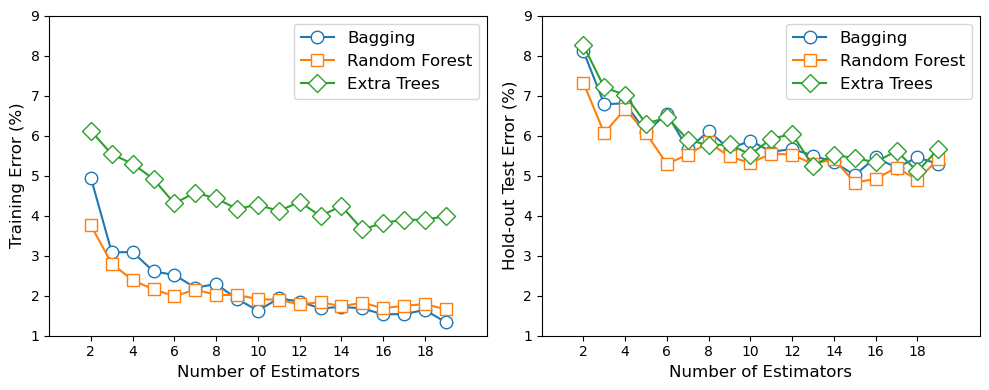

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n_estimator_range = range(2, 20, 1)

# Plot the training error
m = np.mean(bag_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker='o', markersize=9, mfc='w');

m = np.mean(rf_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker='s', markersize=9, mfc='w');

m = np.mean(xt_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=1.5, marker='D', markersize=9, mfc='w');

ax[0].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[0].set_xlabel('Number of Estimators', fontsize=12)
ax[0].set_ylabel('Training Error (%)', fontsize=12)
ax[0].set_xticks(range(2, 20, 2))
ax[0].axis([0, 21, 1, 9])
# ax[0].grid()

# Plot the test error
m = np.mean(bag_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='o', markersize=9, mfc='w');

m = np.mean(rf_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='s', markersize=9, mfc='w');

m = np.mean(xt_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=1.5, marker='D', markersize=9, mfc='w');

ax[1].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[1].set_xlabel('Number of Estimators', fontsize=12)
ax[1].set_ylabel('Hold-out Test Error (%)', fontsize=12)
# ax[1].grid()
ax[1].set_xticks(range(2, 20, 2))
ax[1].axis([0, 21, 1, 9]);
plt.tight_layout()

#### Base learner complexity vs. ensemble performance
Next, we compare the behavior of the three algorithms as the complexity of the base learners increases. There are several ways to control the complexity of the base decision trees: maximum depth, maximum number of leaf nodes, impurity criteria etc. Here, we compare the performance of the three ensemble methods as with complexity as determined by ``max_leaf_nodes``. 

The maximum number of estimators is fixed to 10, which ensures that all three ensemble methods have the same number of estimators in the ensemble.

In [5]:
n_estimators = 16
n_runs = 30
n_leaf_range = [2, 4, 8, 16, 24, 32]

bag_trn_error = np.zeros((n_runs, len(n_leaf_range)))  # Train error for the bagging classifier
rf_trn_error = np.zeros((n_runs, len(n_leaf_range)))   # Train error for the random forest classifier
xt_trn_error = np.zeros((n_runs, len(n_leaf_range)))   # Train error for the extra trees classifier

bag_tst_error = np.zeros((n_runs, len(n_leaf_range)))  # Test error for the bagging classifier
rf_tst_error = np.zeros((n_runs, len(n_leaf_range)))   # Test error for the random forest classifier
xt_tst_error = np.zeros((n_runs, len(n_leaf_range)))   # Test error for the extra trees classifier

for run in range(0, n_runs):

    # Split into train and test sets
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.25, random_state=rng)

    for j, max_leaf_nodes in enumerate(n_leaf_range):
        # Train using bagging
        bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes),
                                        n_estimators=n_estimators, max_samples=0.5, n_jobs=-1, random_state=rng)
        bag_clf.fit(X_trn, y_trn)
        bag_trn_error[run, j] = 1 - accuracy_score(y_trn, bag_clf.predict(X_trn))
        bag_tst_error[run, j] = 1 - accuracy_score(y_tst, bag_clf.predict(X_tst))

        # Train using random forests
        rf_clf = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, 
                                            n_estimators=n_estimators, n_jobs=-1, random_state=rng)
        rf_clf.fit(X_trn, y_trn)
        rf_trn_error[run, j] = 1 - accuracy_score(y_trn, rf_clf.predict(X_trn))
        rf_tst_error[run, j] = 1 - accuracy_score(y_tst, rf_clf.predict(X_tst))

        # Train using extra trees
        xt_clf = ExtraTreesClassifier(max_leaf_nodes=max_leaf_nodes, bootstrap=True,
                                          n_estimators=n_estimators, n_jobs=-1, random_state=rng)
        xt_clf.fit(X_trn, y_trn)
        xt_trn_error[run, j] = 1 - accuracy_score(y_trn, xt_clf.predict(X_trn))
        xt_tst_error[run, j] = 1 - accuracy_score(y_tst, xt_clf.predict(X_tst))
            
    results = (bag_trn_error, bag_tst_error, \
                   rf_trn_error, rf_tst_error, \
                   xt_trn_error, xt_tst_error)

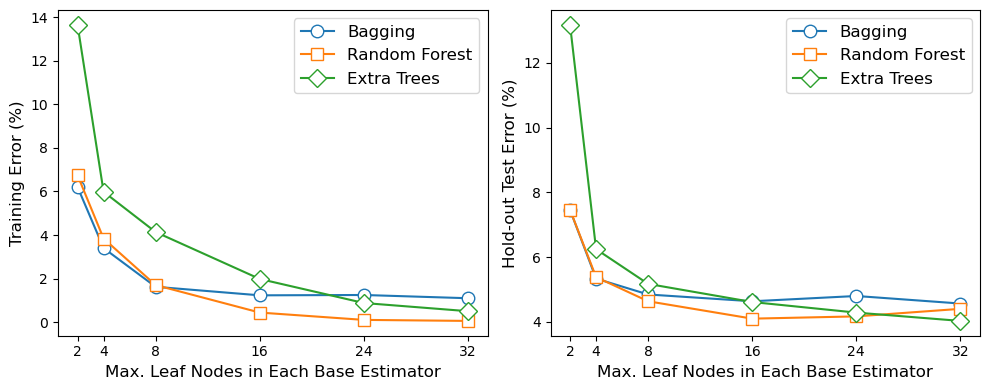

In [6]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n_leaf_range = [2, 4, 8, 16, 24, 32]

# Plot the training error
m = np.mean(bag_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker='o', markersize=9, mfc='w');

m = np.mean(rf_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker='s', markersize=9, mfc='w');

m = np.mean(xt_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=1.5, marker='D', markersize=9, mfc='w');

ax[0].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[0].set_xlabel('Max. Leaf Nodes in Each Base Estimator', fontsize=12)
ax[0].set_ylabel('Training Error (%)', fontsize=12)
ax[0].set_xticks(n_leaf_range)
# ax[0].grid()

# Plot the test error
m = np.mean(bag_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='o', markersize=9, mfc='w');

m = np.mean(rf_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='s', markersize=9, mfc='w');

m = np.mean(xt_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=1.5, marker='D', markersize=9, mfc='w');

ax[1].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=12)
ax[1].set_xlabel('Max. Leaf Nodes in Each Base Estimator', fontsize=12)
ax[1].set_ylabel('Hold-out Test Error (%)', fontsize=12)
ax[1].set_xticks(n_leaf_range)
# ax[1].grid();
plt.tight_layout()
